# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [19]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [20]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [21]:
# Display the DataFrame
df = df_21Oct
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,01:15:00
1,2,1.0,NaN,NaN,00:00:00
2,3,NaN,1.0,NaN,00:00:00
3,4,1.0,NaN,NaN,00:00:00
4,5,NaN,2.0,NaN,05:25:00
...,...,...,...,...,...
106,107,1.0,NaN,NaN,03:30:00
107,108,2.0,NaN,NaN,05:25:00
108,109,2.0,NaN,NaN,05:25:00
109,110,2.0,NaN,NaN,01:35:00


The code in the cells below creates a dictionary Passengers defined as follows:

- Passengers Keys: IDs of passengers.
- Passengers Items: For each ID in Passengers, we specify its *type* (female: 0, male: 1, disabled: 2), its *group number*, and its *transit time*.

Notice that for passengers with a transit time equal to 0 or larger than 2 hours, the transit time in the dictionary is set to $\infty$


In [22]:
def convert_TransitTime(time_val):

    # Convert time to minutes
    total_minutes = time_val.hour * 60 + time_val.minute
    
    # Check if total minutes is greater than 2 hours or equal to 0
    if total_minutes > 120 or total_minutes == 0:
        return float('inf')  # Return infinity
    else:
        return total_minutes

df['TransitTime'] = df['TransitTime'].apply(convert_TransitTime)

In [23]:
# Create Passengers dictionary
Passengers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

transit_times = set()

# Groups : dict[int : List[int]]

Passengers = dict()
i = 1

for group in df.itertuples():
    if not pd.isna(group[2]):
        for k in range(int(group[2])):
            Passengers[i] = {'type': 0, 'group':group[1], 'transit':group[5]}
            number_f += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[3]):
        for k in range(int(group[3])):
            Passengers[i] = {'type': 1, 'group':group[1], 'transit':group[5]}
            number_m += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[4]):
        for k in range(int(group[4])):
            Passengers[i] = {'type': 2, 'group':group[1], 'transit':group[5]}
            number_d += 1
            transit_times.add(group[5])
            i+=1
    
    
Passengers 

{1: {'type': 1, 'group': 1, 'transit': 75.0},
 2: {'type': 0, 'group': 2, 'transit': inf},
 3: {'type': 1, 'group': 3, 'transit': inf},
 4: {'type': 0, 'group': 4, 'transit': inf},
 5: {'type': 1, 'group': 5, 'transit': inf},
 6: {'type': 1, 'group': 5, 'transit': inf},
 7: {'type': 0, 'group': 6, 'transit': inf},
 8: {'type': 0, 'group': 7, 'transit': inf},
 9: {'type': 0, 'group': 8, 'transit': 80.0},
 10: {'type': 1, 'group': 8, 'transit': 80.0},
 11: {'type': 1, 'group': 9, 'transit': inf},
 12: {'type': 0, 'group': 10, 'transit': inf},
 13: {'type': 0, 'group': 11, 'transit': inf},
 14: {'type': 1, 'group': 11, 'transit': inf},
 15: {'type': 1, 'group': 12, 'transit': 70.0},
 16: {'type': 1, 'group': 13, 'transit': inf},
 17: {'type': 0, 'group': 14, 'transit': inf},
 18: {'type': 1, 'group': 14, 'transit': inf},
 19: {'type': 1, 'group': 15, 'transit': inf},
 20: {'type': 1, 'group': 16, 'transit': 95.0},
 21: {'type': 0, 'group': 17, 'transit': 60.0},
 22: {'type': 1, 'group': 1

We define a dictionnary *Groups*, containing as keys the group ID and as valuea, the list of the members of the group

In [96]:
Groups = dict()

print(Passengers)

for i, passager in Passengers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{1: {'type': 1, 'group': 1, 'transit': 75.0}, 2: {'type': 0, 'group': 2, 'transit': inf}, 3: {'type': 1, 'group': 3, 'transit': inf}, 4: {'type': 0, 'group': 4, 'transit': inf}, 5: {'type': 1, 'group': 5, 'transit': inf}, 6: {'type': 1, 'group': 5, 'transit': inf}, 7: {'type': 0, 'group': 6, 'transit': inf}, 8: {'type': 0, 'group': 7, 'transit': inf}, 9: {'type': 0, 'group': 8, 'transit': 80.0}, 10: {'type': 1, 'group': 8, 'transit': 80.0}, 11: {'type': 1, 'group': 9, 'transit': inf}, 12: {'type': 0, 'group': 10, 'transit': inf}, 13: {'type': 0, 'group': 11, 'transit': inf}, 14: {'type': 1, 'group': 11, 'transit': inf}, 15: {'type': 1, 'group': 12, 'transit': 70.0}, 16: {'type': 1, 'group': 13, 'transit': inf}, 17: {'type': 0, 'group': 14, 'transit': inf}, 18: {'type': 1, 'group': 14, 'transit': inf}, 19: {'type': 1, 'group': 15, 'transit': inf}, 20: {'type': 1, 'group': 16, 'transit': 95.0}, 21: {'type': 0, 'group': 17, 'transit': 60.0}, 22: {'type': 1, 'group': 17, 'transit': 60.0}, 

{5: [5, 6],
 8: [9, 10],
 11: [13, 14],
 14: [17, 18],
 17: [21, 22],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 23: [35, 36],
 24: [37, 38],
 27: [41, 42],
 31: [46, 47],
 34: [50, 51],
 35: [52, 53],
 39: [57, 58],
 45: [64, 65],
 51: [71, 72],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 59: [83, 84],
 61: [86, 87],
 63: [89, 90],
 65: [92, 93, 94],
 68: [97, 98],
 71: [101, 102],
 77: [108, 109],
 87: [119, 120],
 92: [125, 126],
 95: [129, 130],
 103: [138, 139],
 104: [140, 141],
 108: [145, 146],
 109: [147, 148],
 110: [149, 150]}

Definition of parameters necessary for the following steps

In [25]:
weight_f = 70
weight_m = 85
weight_d = 92.5

if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #Aircraft model A320
else :
    number_of_rows = 35 #Aircraft model A321

number_of_columns = 7 # adding the aisle


## Model

Defining the relevant variables of the problem

The binary variables $AssignmentVarDict_{i,j,k}$ specify whether the seat located at position $(i,j)$ is occupied by passenger $k$.

In [26]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passengers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


The integer variables $i_{\text{min}}[g]$ and $i_{\text{max}}[g]$ (resp. $j_{\text{min}}[g]$ and $j_{\text{max}}[g]$) give the value
of $i$ (resp. the value of $j$) that is the smallest and the largest \
in group $g$


In [27]:

# Variables i_{min}, i_{max}, j_{min} et j_{max}
i_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_min({g})') 
            for g in Groups.keys()}

i_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_max({g})') 
            for g in Groups.keys()}

j_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns , name=f'j_min({g})') 
            for g in Groups.keys()}

j_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns  , name=f'j_max({g})') 
            for g in Groups.keys()}


### The constraints 

- Constraints related to the definition of variables $i_{\text{min}}[g]$, $i_{\text{max}}[g]$, $j_{\text{min}}[g]$, $j_{\text{max}}[g]$

In [28]:


i_min_Passagers_Group = {(g,p) : m.addConstr(i_min[g] <= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

i_max_Passagers_Group = {(g,p) : m.addConstr(i_max[g] >= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_min_Passagers_Group = {(g,p) : m.addConstr(j_min[g] <= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_max_Passagers_Group = {(g,p) : m.addConstr(j_max[g] >= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }


- Every person has one seat

In [29]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passengers)+1) }

- Every seat is allocated to a single person

In [30]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Aisle seats are always free

In [31]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [32]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [33]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [34]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passengers) + 1)
                                               if Passengers[k]['type'] == 2}

for k in range(1, len(Passengers) + 1):
    if Passengers[k]['type'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Time Objectif

- Transit time

In [35]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passengers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passengers)+1)
                      if Passengers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [36]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 4.07                                                    



In [37]:
z_old = round(transit_obj.getValue(), 2)

- Transit time visualization

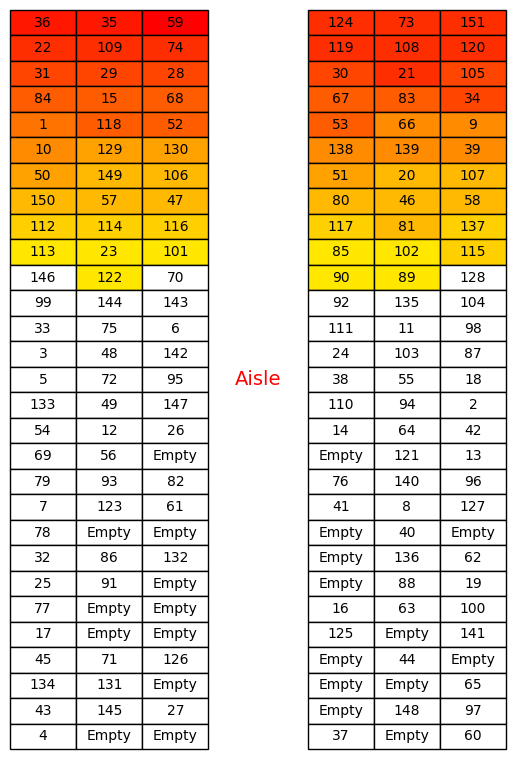

In [38]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Grouping Objectif

In [39]:

obj_grouping = quicksum([10*(i_max[g] - i_min[g]) + (j_max[g] - j_min[g])
                        for g in Groups.keys()])

m.setObjective(obj_grouping, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

Set parameter OutputFlag to value 1


## Optimisation


In [40]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




Set parameter TimeLimit to value 100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 687 rows, 30793 columns and 249497 nonzeros
Model fingerprint: 0x0e9f2f1f
Variable types: 0 continuous, 30793 integer (30653 binary)
Coefficient statistics:
  Matrix range     [7e-03, 3e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 10010

Presolve removed 59 rows and 4379 columns
Presolve time: 0.23s
Presolved: 628 rows, 26414 columns, 172429 nonzeros
Variable types: 0 continuous, 26414 integer (26274 binary)
Found heuristic solution: objective 1596.0000000

Root relaxation: objective -1.580958e-13, 2511 iterations, 0.24 seconds (0.65 work units)

    Nodes    |    Current Node

- Grouping visualisation

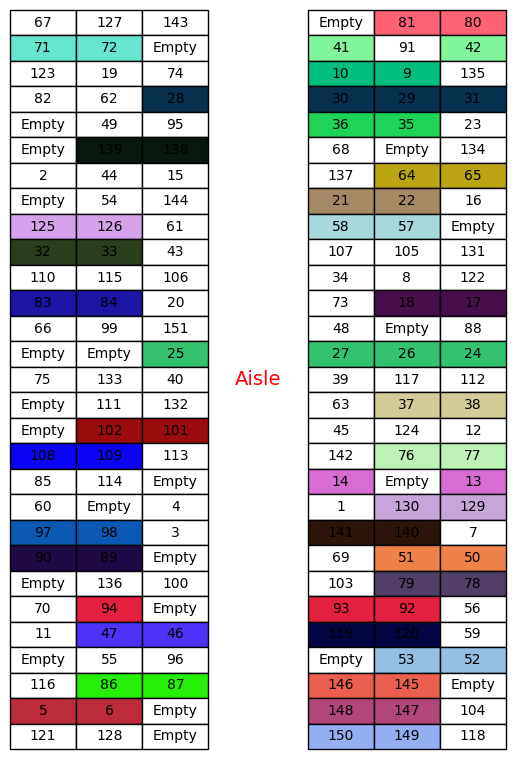

In [41]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Coupling both objectives

In [42]:
m.setObjective(0.7*obj_grouping + 0.3*transit_obj, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

## Optimisation

In [43]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 687 rows, 30793 columns and 249497 nonzeros
Model fingerprint: 0x9229d7f1
Variable types: 0 continuous, 30793 integer (30653 binary)
Coefficient statistics:
  Matrix range     [7e-03, 3e+01]
  Objective range  [3e-03, 7e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 35.4929

Presolve removed 59 rows and 4379 columns
Presolve time: 0.64s
Presolved: 628 rows, 26414 columns, 172429 nonzeros
Variable types: 0 continuous, 26414 integer (26274 binary)
Found heuristic solution: objective 35.0101851

Root relaxation: objective 1.221447e+00, 3459 iterations, 0.43 seconds (0.37 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     

- Transit time visualisation

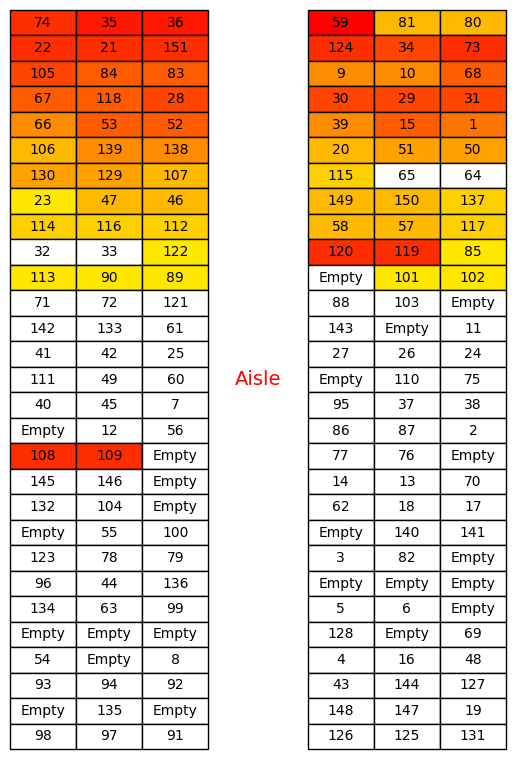

In [44]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

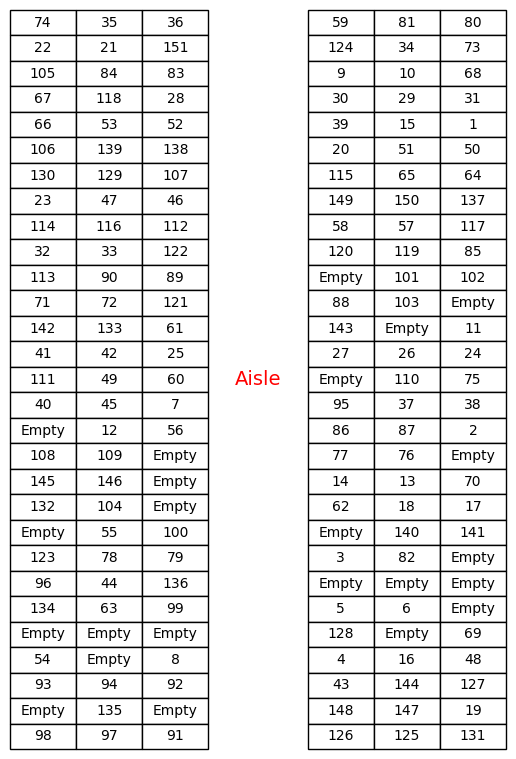

In [45]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Groups vizualisation

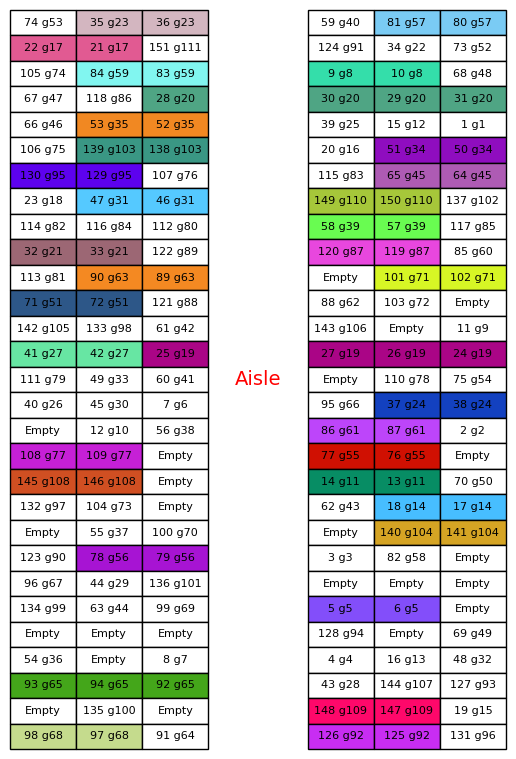

In [46]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Metrics

- Transit metric

In [47]:

z_new = round(transit_obj.getValue(), 2)


print("The satisfaction level related to transit time:", (1- (z_new- z_old)/z_old) * 100, " %" )

The satisfaction level related to transit time: 86.73218673218673  %


- Grouping metric

In [84]:
# Définition des constantes pour les niveaux de satisfaction
SATISFIED = 1.0
MEDIUM_SATISFIED = 0.5
NOT_SATISFIED = 0.0

# Initialisation des variables pour les scores de satisfaction
satisfaction_scores = []

for group, passengers in Groups.items():
    print(passengers)
    for pass_id in passengers:
        seat_positions = [(i, j) for i in range(1, number_of_rows+1)
                            for j in range(1, number_of_columns+1)
                            if AssignmenVarDict.get((i, j, pass_id), 0).x == 1]
        if seat_positions:  # Vérifie si la liste n'est pas vide
            seat_position = seat_positions[0]  # Prend le premier élément
            print(f"** Le passager {pass_id} est assis à la position {seat_position}")
        else:
            print(f"Aucun siège trouvé pour le passager {pass_id}. Vérifiez l'indexation et les données.")
            
        i, j = seat_position
        neighbors = [(i, j-1), (i, j+1)]
        satisfaction = 0
        for neighbor in neighbors:
            ni, nj = neighbor
            if 1 <= nj <= number_of_columns:
                if nj == 4 or j == 4:  # S'ils sont séparés par l'allée, attribuez MEDIUM_SATISFIED seulement si dans la même rangée
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, Medium")
                        satisfaction = max(satisfaction, MEDIUM_SATISFIED)
                elif nj != 4:
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if (other_pass_id != pass_id and ni == i)):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, True")
                        satisfaction = max(satisfaction, SATISFIED)
                    else :
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, False")
                        satisfaction = max(satisfaction, NOT_SATISFIED)
        satisfaction_scores.append(satisfaction)
        print(f"** Passager {pass_id} -- satisfaction {satisfaction}\n")

for pass_id in range(1, len(Passengers) + 1):
    if all(pass_id not in passengers for _, passengers in Groups.items()):
        # Ce passager est seul
        # print(f"Le passager {pass_id} est seul et est automatiquement SATISFIED.")
        satisfaction_scores.append(SATISFIED)

# Calcul du score de groupement moyen (pourcentage de satisfaction)
grouping_score = sum(satisfaction_scores) / len(satisfaction_scores)

# Retourner le score de groupement en pourcentage
grouping_score_percentage = grouping_score * 100
grouping_score_percentage


[5, 6]
** Le passager 5 est assis à la position (24, 5)
Pass 5, Seat (24, 5), Neighbor (24, 6), True
** Passager 5 -- satisfaction 1.0

** Le passager 6 est assis à la position (24, 6)
Pass 6, Seat (24, 6), Neighbor (24, 5), True
Pass 6, Seat (24, 6), Neighbor (24, 7), False
** Passager 6 -- satisfaction 1.0

[9, 10]
** Le passager 9 est assis à la position (3, 5)
Pass 9, Seat (3, 5), Neighbor (3, 6), True
** Passager 9 -- satisfaction 1.0

** Le passager 10 est assis à la position (3, 6)
Pass 10, Seat (3, 6), Neighbor (3, 5), True
Pass 10, Seat (3, 6), Neighbor (3, 7), False
** Passager 10 -- satisfaction 1.0

[13, 14]
** Le passager 13 est assis à la position (19, 6)
Pass 13, Seat (19, 6), Neighbor (19, 5), True
Pass 13, Seat (19, 6), Neighbor (19, 7), False
** Passager 13 -- satisfaction 1.0

** Le passager 14 est assis à la position (19, 5)
Pass 14, Seat (19, 5), Neighbor (19, 6), True
** Passager 14 -- satisfaction 1.0

[17, 18]
** Le passager 17 est assis à la position (20, 7)
Pa

98.67549668874173

## Partie Dynamique

In [119]:
import random

# print(Groups)

def shuffle_groups(group_list, proportion):
    group_list = list(group_list)
    # Mélanger la liste de groupes de manière aléatoire
    random.shuffle(group_list)
    
    # Calculer le nombre de groupes à sélectionner
    num_selected = int(len(group_list) * proportion)
    
    # Sélectionner les groupes en fonction de la proportion spécifiée
    selected_groups = dict(group_list[:num_selected])
    
    return selected_groups


# Appel de la fonction shuffle_groups avec une proportion de 0.5 (50%)
groupes_selectionnes = shuffle_groups(Groups.items(), proportion=0.4)

print(groupes_selectionnes)
# Affichage des groupes sélectionnés de manière aléatoire
print("Groupes sélectionnés de manière aléatoire:")
for group, choices in groupes_selectionnes.items():
    print(f"Groupe: {group}, Choix possibles: {choices}")

{71: [101, 102], 35: [52, 53], 68: [97, 98], 24: [37, 38], 17: [21, 22], 11: [13, 14], 23: [35, 36], 27: [41, 42], 5: [5, 6], 8: [9, 10], 61: [86, 87], 31: [46, 47], 34: [50, 51], 21: [32, 33]}
Groupes sélectionnés de manière aléatoire:
Groupe: 71, Choix possibles: [101, 102]
Groupe: 35, Choix possibles: [52, 53]
Groupe: 68, Choix possibles: [97, 98]
Groupe: 24, Choix possibles: [37, 38]
Groupe: 17, Choix possibles: [21, 22]
Groupe: 11, Choix possibles: [13, 14]
Groupe: 23, Choix possibles: [35, 36]
Groupe: 27, Choix possibles: [41, 42]
Groupe: 5, Choix possibles: [5, 6]
Groupe: 8, Choix possibles: [9, 10]
Groupe: 61, Choix possibles: [86, 87]
Groupe: 31, Choix possibles: [46, 47]
Groupe: 34, Choix possibles: [50, 51]
Groupe: 21, Choix possibles: [32, 33]


In [120]:
import random

def assign_permutable_groups(groups, selected_groups):

    assigned_groups = {}
    
    for selected_group, selected_choices in selected_groups.items():
        # Créer une liste pour stocker les groupes associés pour permutation
        permutation_candidates = []
        
        # Parcourir les groupes de `groups` pour trouver les groupes compatibles pour permutation
        for group, choices in Groups.items():
            # print(sum(Passengers[k]['type'] for k in selected_choices))
            # print(sum(Passengers[k]['type'] for k in choices))
            if len(selected_choices) == len(choices) and sum(Passengers[k]['type'] for k in selected_choices) == sum(Passengers[k]['type'] for k in choices):
                permutation_candidates.append(group)
        
        # Exclure le groupe sélectionné lui-même de la liste des candidats
        permutation_candidates.remove(selected_group)
        
        # Sélectionner un groupe de manière aléatoire parmi les candidats
        assigned_group = random.choice(permutation_candidates)
        
        # Ajouter la paire de groupe sélectionné et groupe associé à assigned_groups
        assigned_groups[selected_group] = assigned_group
    
    return assigned_groups

# Utilisation de la fonction assign_permutable_groups
# Groups = {5: [5, 6], 108: [145, 146], 24: [37, 38]}
# groupes_selectionnes = {5: [5, 6], 108: [145, 146]}

# Attribution des groupes associés pour permutation
groupes_assignes = assign_permutable_groups(Groups, groupes_selectionnes)

# Affichage des groupes sélectionnés et de leurs groupes associés pour permutation
print("Groupes sélectionnés et leurs groupes associés pour permutation:")
for selected_group, assigned_group in groupes_assignes.items():
    print(f"Groupe sélectionné: {selected_group}, Groupe associé pour permutation: {assigned_group, Groups[assigned_group]}")


Groupes sélectionnés et leurs groupes associés pour permutation:
Groupe sélectionné: 71, Groupe associé pour permutation: (11, [13, 14])
Groupe sélectionné: 35, Groupe associé pour permutation: (77, [108, 109])
Groupe sélectionné: 68, Groupe associé pour permutation: (24, [37, 38])
Groupe sélectionné: 24, Groupe associé pour permutation: (23, [35, 36])
Groupe sélectionné: 17, Groupe associé pour permutation: (104, [140, 141])
Groupe sélectionné: 11, Groupe associé pour permutation: (61, [86, 87])
Groupe sélectionné: 23, Groupe associé pour permutation: (55, [76, 77])
Groupe sélectionné: 27, Groupe associé pour permutation: (5, [5, 6])
Groupe sélectionné: 5, Groupe associé pour permutation: (27, [41, 42])
Groupe sélectionné: 8, Groupe associé pour permutation: (77, [108, 109])
Groupe sélectionné: 61, Groupe associé pour permutation: (17, [21, 22])
Groupe sélectionné: 31, Groupe associé pour permutation: (95, [129, 130])
Groupe sélectionné: 34, Groupe associé pour permutation: (31, [46, 